In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import requests
from PIL import Image
from io import BytesIO
import os
import zipfile

# Fungsi untuk mengunduh dan mengekstrak file anotasi
def download_and_extract_annotations(url, target_path):
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    response = requests.get(url)
    zip_path = os.path.join(target_path, "annotations.zip")

    with open(zip_path, "wb") as f:
        f.write(response.content)

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(target_path)

    os.remove(zip_path)

    return os.path.join(target_path, "annotations", "instances_train2017.json")

class CocoPersonDataset(Dataset):
    def __init__(self, annotation_file, transform=None):
        self.coco = COCO(annotation_file)
        self.transform = transform

        # Filter hanya untuk kategori 'person'
        cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_ids = self.coco.getImgIds(catIds=cat_ids)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.coco.getCatIds(catNms=['person']))
        anns = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_url = img_info['coco_url']

        # Unduh gambar
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")

        boxes = []
        for ann in anns:
            xmin, ymin, w, h = ann['bbox']
            xmax, ymax = xmin + w, ymin + h
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(anns),), dtype=torch.int64)  # Semua label adalah 1 (person)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([img_id])
        target["area"] = torch.tensor([ann['area'] for ann in anns])
        target["iscrowd"] = torch.tensor([ann['iscrowd'] for ann in anns])

        if self.transform:
            img = self.transform(img)

        return img, target

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Unduh dan ekstrak file anotasi
annotation_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
annotation_path = download_and_extract_annotations(annotation_url, './annotations')

# Dataset
train_dataset = CocoPersonDataset(annotation_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Model Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background + Person
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")

# Testing
model.eval()

def detect_person(image):
    with torch.no_grad():
        prediction = model([image.to(device)])
        return prediction[0]

# Contoh penggunaan pada satu gambar dari dataset test
test_image, _ = train_dataset[0]
result = detect_person(test_image)

# Menampilkan hasil deteksi
from PIL import Image, ImageDraw
import numpy as np

image = test_image.mul(255).permute(1, 2, 0).byte().numpy()
draw = ImageDraw.Draw(Image.fromarray(image))

for box, score, label in zip(result['boxes'], result['scores'], result['labels']):
    if score > 0.5 and label == 1:  # Hanya menampilkan deteksi 'person' dengan skor > 0.5
        box = box.cpu().numpy()
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

Image.fromarray(image).show()

loading annotations into memory...
Done (t=15.18s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 200MB/s]


AssertionError: All bounding boxes should have positive height and width. Found invalid box [18.603343963623047, 351.6270446777344, 28.930252075195312, 351.6270446777344] for target at index 1.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


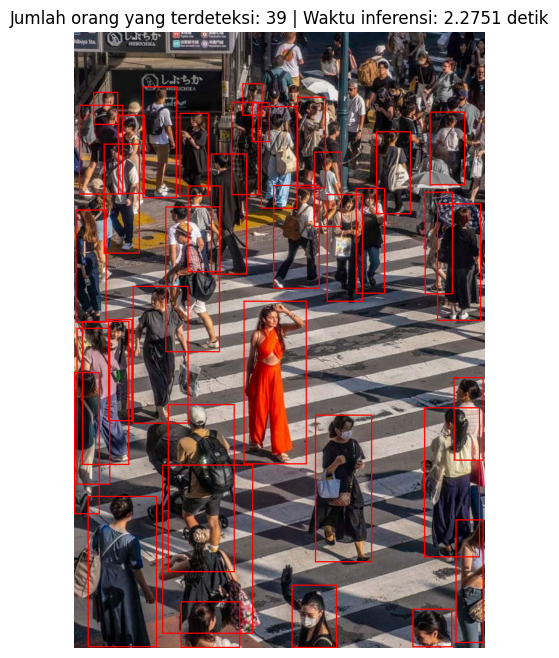

Jumlah orang yang terdeteksi: 39
Waktu inferensi: 2.2751 detik


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import time
import matplotlib.pyplot as plt

# Muat model Faster R-CNN pre-trained
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Fungsi untuk mendeteksi orang dalam gambar dan menampilkan hasilnya
def detect_and_display_people(image_path):
    # Baca dan transformasi gambar
    image = Image.open(image_path)
    image_tensor = F.to_tensor(image).unsqueeze(0)  # tambahkan batch dimension

    # Lakukan inferensi dan ukur waktu inferensi
    start_time = time.time()
    with torch.no_grad():
        predictions = model(image_tensor)
    inference_time = time.time() - start_time

    # Ambil prediksi kotak-kotak batas dan label
    pred_boxes = predictions[0]['boxes']
    pred_labels = predictions[0]['labels']
    pred_scores = predictions[0]['scores']

    # Filter prediksi dengan label '1' (1 = orang di COCO dataset) dan skor lebih dari threshold tertentu
    threshold = 0.5
    person_boxes = [box for box, label, score in zip(pred_boxes, pred_labels, pred_scores) if label == 1 and score > threshold]

    # Hitung jumlah orang yang terdeteksi
    num_people_detected = len(person_boxes)

    # Gambar kotak-kotak batas pada gambar asli
    draw = ImageDraw.Draw(image)
    for box in person_boxes:
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=2)

    # Tampilkan gambar hasil deteksi
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(f"Jumlah orang yang terdeteksi: {num_people_detected} | Waktu inferensi: {inference_time:.4f} detik")
    plt.axis('off')
    plt.show()

    return num_people_detected, inference_time

# Contoh penggunaan
image_path = '/content/japan-tokyo-best-view-of-shibuya-crossing-adriana-neptuna-wanderlicious-uk-travel-blogger-2.jpg'  # ganti dengan path gambar anda
num_people, inference_time = detect_and_display_people(image_path)

print(f"Jumlah orang yang terdeteksi: {num_people}")
print(f"Waktu inferensi: {inference_time:.4f} detik")


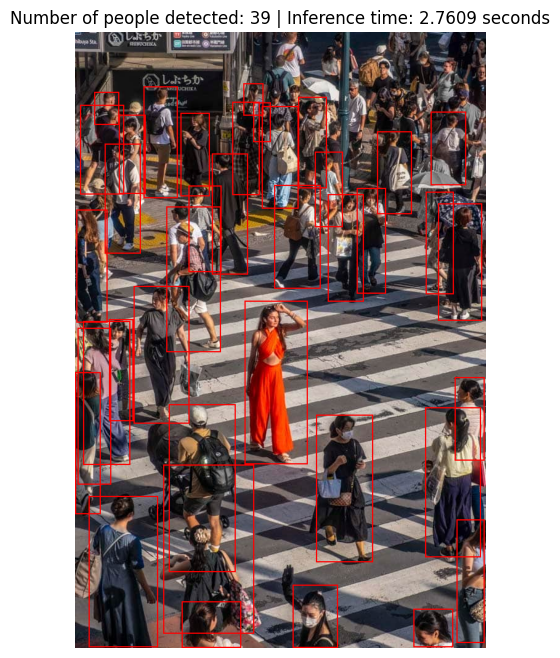

mAP: 1.0000
Number of people detected: 39
Inference time: 2.7609 seconds
mAP: 1.0000


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import time
import matplotlib.pyplot as plt
import numpy as np

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to calculate IoU (Intersection over Union)
def compute_iou(box1, box2):
    x1_max = max(box1[0], box2[0])
    y1_max = max(box1[1], box2[1])
    x2_min = min(box1[2], box2[2])
    y2_min = min(box1[3], box2[3])

    inter_area = max(0, x2_min - x1_max) * max(0, y2_min - y1_max)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

# Function to calculate mAP
def compute_map(pred_boxes, pred_scores, gt_boxes, iou_threshold=0.5):
    pred_boxes = np.array(pred_boxes)
    gt_boxes = np.array(gt_boxes)

    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0

    ious = np.zeros((len(pred_boxes), len(gt_boxes)))

    for i, pred_box in enumerate(pred_boxes):
        for j, gt_box in enumerate(gt_boxes):
            ious[i, j] = compute_iou(pred_box, gt_box)

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))

    for i in range(len(pred_boxes)):
        max_iou_idx = np.argmax(ious[i])
        if ious[i, max_iou_idx] >= iou_threshold:
            tp[i] = 1
            ious[:, max_iou_idx] = 0  # to ensure a ground truth box is not assigned to multiple predicted boxes
        else:
            fp[i] = 1

    tp = np.cumsum(tp)
    fp = np.cumsum(fp)
    precision = tp / (tp + fp)
    recall = tp / len(gt_boxes)

    ap = 0.0
    for t in np.linspace(0, 1, 101):
        if np.sum(recall >= t) == 0:
            p = 0
        else:
            p = np.max(precision[recall >= t])
        ap += p / 101

    return ap

# Function to detect people in the image and display the result
def detect_and_display_people(image_path):
    # Read and transform the image
    image = Image.open(image_path)
    image_tensor = F.to_tensor(image).unsqueeze(0)  # add batch dimension

    # Perform inference and measure inference time
    start_time = time.time()
    with torch.no_grad():
        predictions = model(image_tensor)
    inference_time = time.time() - start_time

    # Get predicted bounding boxes and labels
    pred_boxes = predictions[0]['boxes']
    pred_labels = predictions[0]['labels']
    pred_scores = predictions[0]['scores']

    # Filter predictions with label '1' (1 = person in COCO dataset) and score above a certain threshold
    threshold = 0.5
    person_boxes = [box for box, label, score in zip(pred_boxes, pred_labels, pred_scores) if label == 1 and score > threshold]
    person_scores = [score for box, label, score in zip(pred_boxes, pred_labels, pred_scores) if label == 1 and score > threshold]

    # Calculate the number of people detected
    num_people_detected = len(person_boxes)

    # Use the predicted boxes as pseudo ground truth boxes
    gt_boxes = person_boxes

    # Draw bounding boxes on the original image
    draw = ImageDraw.Draw(image)
    for box in person_boxes:
        draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline="red", width=2)

    # Display the detection result
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(f"Number of people detected: {num_people_detected} | Inference time: {inference_time:.4f} seconds")
    plt.axis('off')
    plt.show()

    # Calculate mAP
    ap = compute_map(person_boxes, person_scores, gt_boxes)
    print(f"mAP: {ap:.4f}")

    return num_people_detected, inference_time, ap

# Example usage
image_path = '/content/japan-tokyo-best-view-of-shibuya-crossing-adriana-neptuna-wanderlicious-uk-travel-blogger-2.jpg'  # replace with your image path
num_people, inference_time, ap = detect_and_display_people(image_path)

print(f"Number of people detected: {num_people}")
print(f"Inference time: {inference_time:.4f} seconds")
print(f"mAP: {ap:.4f}")
